##### Copyright 2018 The TensorFlow Authors.


In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Distributed training with TensorFlow

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/distributed_training"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/distributed_training.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/distributed_training.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/distributed_training.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

`tf.distribute.Strategy` is a TensorFlow API to distribute training 
across multiple GPUs, multiple machines or TPUs. Using this API, you can distribute your existing models and training code with minimal code changes.

`tf.distribute.Strategy` has been designed with these key goals in mind:

* Easy to use and support multiple user segments, including researchers, ML engineers, etc.
* Provide good performance out of the box.
* Easy switching between strategies.

`tf.distribute.Strategy` can be used with a high-level API like [Keras](https://www.tensorflow.org/guide/keras), and can also be used to distribute custom training loops (and, in general, any computation using TensorFlow).

In TensorFlow 2.x, you can execute your programs eagerly, or in a graph using [`tf.function`](function.ipynb). `tf.distribute.Strategy` intends to support both these modes of execution, but works best with `tf.function`. Eager mode is only recommended for debugging purpose and not supported for `TPUStrategy`. Although training is the focus of this guide, this API can also be used for distributing evaluation and prediction on different platforms.

*> Better with static comp. graphs*

You can use `tf.distribute.Strategy` with very few changes to your code, because we have changed the underlying components of TensorFlow to become strategy-aware. This includes variables, layers, models, optimizers, metrics, summaries, and checkpoints.

In this guide, we explain various types of strategies and how you can use them in different situations. To learn how to debug performance issues, see the [Optimize TensorFlow GPU Performance](gpu_performance_analysis.md) guide.

Note: For a deeper understanding of the concepts, please watch [this deep-dive presentation](https://youtu.be/jKV53r9-H14). This is especially recommended if you plan to write your own training loop.


In [3]:
# Import TensorFlow
import tensorflow as tf

## Types of strategies
`tf.distribute.Strategy` intends to cover a number of use cases along different axes. Some of these combinations are currently supported and others will be added in the future. Some of these axes are:

* *Synchronous vs asynchronous training:* These are two common ways of distributing training with data parallelism. In sync training, all workers train over different slices of input data in sync, and aggregating gradients at each step. In async training, all workers are independently training over the input data and updating variables asynchronously. Typically sync training is supported via all-reduce and async through parameter server architecture.
* *Hardware platform:* You may want to scale your training onto multiple GPUs on one machine, or multiple machines in a network (with 0 or more GPUs each), or on Cloud TPUs.

In order to support these use cases, there are six strategies available. The next section explains which of these are supported in which scenarios in TF. Here is a quick overview:

| Training API          	| MirroredStrategy  	| TPUStrategy         	| MultiWorkerMirroredStrategy     	| CentralStorageStrategy          	| ParameterServerStrategy  	|
|:-----------------------	|:-------------------	|:---------------------	|:---------------------------------	|:---------------------------------	|:--------------------------	|
| **Keras API**             	| Supported         	|  Supported 	| Experimental support 	| Experimental support 	| Supported planned post 2.3 	|
| **Custom training loop**  	| Supported 	| Supported   	| Experimental support            	| Experimental support           	| Supported planned post 2.3         	|
| **Estimator API**         	| Limited Support         	| Not supported           	| Limited Support                       	| Limited Support                       	| Limited Support                	|

Note: [Experimental support](https://www.tensorflow.org/guide/versions#what_is_not_covered) means the APIs are not covered by any compatibilities guarantees.

Note: Estimator support is limited. Basic training and evaluation are experimental, and advanced features—such as scaffold—are not implemented. We recommend using Keras or custom training loops if a use case is not covered.

Estimator & Keras - both high level abstractions.

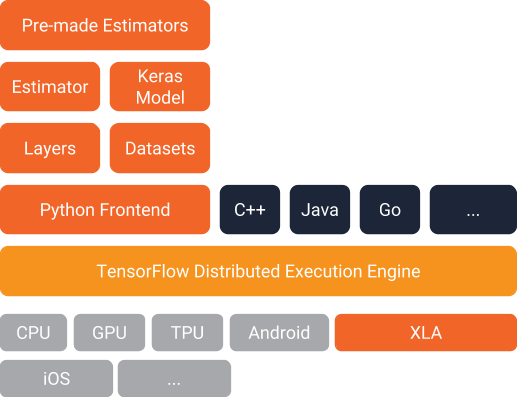

### MirroredStrategy
`tf.distribute.MirroredStrategy` supports synchronous distributed training on multiple GPUs on one machine. It creates one replica per GPU device. Each variable in the model is mirrored across all the replicas. Together, these variables form a single conceptual variable called `MirroredVariable`. These variables are kept in sync with each other by applying identical updates.

Efficient all-reduce algorithms are used to communicate the variable updates across the devices.
All-reduce aggregates tensors across all the devices by adding them up, and makes them available on each device.
It’s a fused algorithm that is very efficient and can reduce the overhead of synchronization significantly. There are many all-reduce algorithms and implementations available, depending on the type of communication available between devices. By default, it uses NVIDIA NCCL as the all-reduce implementation. You can choose from a few other options, or write your own.

Here is the simplest way of creating `MirroredStrategy`:


In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


This will create a `MirroredStrategy` instance which will use all the GPUs that are visible to TensorFlow, and use NCCL as the cross device communication.

If you wish to use only some of the GPUs on your machine, you can do so like this:

In [5]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


If you wish to override the cross device communication, you can do so using the `cross_device_ops` argument by supplying an instance of `tf.distribute.CrossDeviceOps`. Currently,  `tf.distribute.HierarchicalCopyAllReduce` and `tf.distribute.ReductionToOneDevice` are two options other than `tf.distribute.NcclAllReduce` which is the default.

In [6]:
mirrored_strategy = tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


### TPUStrategy
`tf.distribute.TPUStrategy` lets you run your TensorFlow training on Tensor Processing Units (TPUs). TPUs are Google's specialized ASICs designed to dramatically accelerate machine learning workloads. They are available on Google Colab, the [TensorFlow Research Cloud](https://www.tensorflow.org/tfrc) and [Cloud TPU](https://cloud.google.com/tpu).

In terms of distributed training architecture, `TPUStrategy` is the same `MirroredStrategy` - it implements synchronous distributed training. TPUs provide their own implementation of efficient all-reduce and other collective operations across multiple TPU cores, which are used in `TPUStrategy`.

Here is how you would instantiate `TPUStrategy`:

Note: To run this code in Colab, you should select TPU as the Colab runtime. See [TensorFlow TPU Guide](https://www.tensorflow.org/guide/tpu).

```
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
    tpu=tpu_address)
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
tpu_strategy = tf.distribute.TPUStrategy(cluster_resolver)
```


The `TPUClusterResolver` instance helps locate the TPUs. In Colab, you don't need to specify any arguments to it.

If you want to use this for Cloud TPUs:
- You must specify the name of your TPU resource in the `tpu` argument.
- You must initialize the tpu system explicitly at the *start* of the program. This is required before TPUs can be used for computation. Initializing the tpu system also wipes out the TPU memory, so it's important to complete this step first in order to avoid losing state.

### MultiWorkerMirroredStrategy

`tf.distribute.MultiWorkerMirroredStrategy` is very similar to `MirroredStrategy`. It implements synchronous distributed training across multiple workers, each with potentially multiple GPUs. Similar to `tf.distribute.MirroredStrategy`, it creates copies of all variables in the model on each device across all workers.

Here is the simplest way of creating `MultiWorkerMirroredStrategy`:

In [7]:
strategy = tf.distribute.MultiWorkerMirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


`MultiWorkerMirroredStrategy` has two implementations for cross-device communications.  `CommunicationImplementation.RING` is RPC-based and supports both CPU and GPU.  `CommunicationImplementation.NCCL` uses [Nvidia's NCCL](https://developer.nvidia.com/nccl) and provides the state of art performance on GPU, but it doesn't support CPU.  `CollectiveCommunication.AUTO` defers the choice to Tensorflow.   You can specify them in the following way:


In [8]:
communication_options = tf.distribute.experimental.CommunicationOptions(
    implementation=tf.distribute.experimental.CommunicationImplementation.NCCL)
strategy = tf.distribute.MultiWorkerMirroredStrategy(
    communication_options=communication_options)

INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.NCCL


One of the key differences to get multi worker training going, as compared to multi-GPU training, is the multi-worker setup. The `TF_CONFIG` environment variable is the standard way in TensorFlow to specify the cluster configuration to each worker that is part of the cluster. Learn more about [setting up TF_CONFIG](#TF_CONFIG).

### ParameterServerStrategy
Parameter server training is a common data-parallel method to scale up model training on multiple machines. A parameter server training cluster consists of workers and parameter servers. Variables are created on parameter servers and they are read and updated by workers in each step. Please see the [parameter server training tutorial](../tutorials/distribute/parameter_server_training.ipynb) for details.

TensorFlow 2 parameter server training uses a central-coordinator based architecture via the `tf.distribute.experimental.coordinator.ClusterCoordinator` class. 

In this implementation the `worker` and `parameter server` tasks run `tf.distribute.Server`s that listen for tasks from the coordinator. The coordinator creates resources, dispatches training tasks, writes checkpoints, and deals with task failures.

In the programming running on the coordinator, you will use a `ParameterServerStrategy` object to define a training step and use a `ClusterCoordinator` to dispatch training steps to remote workers. Here is the simplest way to create them:

```Python
strategy = tf.distribute.experimental.ParameterServerStrategy(
    tf.distribute.cluster_resolver.TFConfigClusterResolver(),
    variable_partitioner=variable_partitioner)
coordinator = tf.distribute.experimental.coordinator.ClusterCoordinator(
    strategy)
```

Note you will need to configure TF_CONFIG environment variable if you use `TFConfigClusterResolver`. It is similar to  [TF_CONFIG](#TF_CONFIG) in `MultiWorkerMirroredStrategy` but has additional caveats.

In TF 1, `ParameterServerStrategy` is available only with estimator via `tf.compat.v1.distribute.experimental.ParameterServerStrategy` symbol.

Note: This strategy is [`experimental`](https://www.tensorflow.org/guide/versions#what_is_not_covered) as it is currently under active development.

### CentralStorageStrategy
`tf.distribute.experimental.CentralStorageStrategy` does synchronous training as well. Variables are not mirrored, instead they are placed on the CPU and operations are replicated across all local GPUs. If there is only one GPU, all variables and operations will be placed on that GPU.

Create an instance of `CentralStorageStrategy` by:


In [9]:
central_storage_strategy = tf.distribute.experimental.CentralStorageStrategy()

INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:CPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:CPU:0'


This will create a `CentralStorageStrategy` instance which will use all visible GPUs and CPU. Update to variables on replicas will be aggregated before being applied to variables.

Note: This strategy is [`experimental`](https://www.tensorflow.org/guide/versions#what_is_not_covered) as it is currently a work in progress. 

### Other strategies

In addition to the above strategies, there are two other strategies which might be useful for prototyping and debugging when using `tf.distribute` APIs.

#### Default Strategy

Default strategy is a distribution strategy which is present when no explicit distribution strategy is in scope. It implements the `tf.distribute.Strategy` interface but is a pass-through and provides no actual distribution. For instance, `strategy.run(fn)` will simply call `fn`. Code written using this strategy should behave exactly as code written without any strategy. You can think of it as a "no-op" strategy.

Default strategy is a singleton - and one cannot create more instances of it. It can be obtained using `tf.distribute.get_strategy()` outside any explicit strategy's scope (the same API that can be used to get the current strategy inside an explicit strategy's scope). 

In [10]:
default_strategy = tf.distribute.get_strategy()

This strategy serves two main purposes:

* It allows writing distribution aware library code unconditionally. For example, in `tf.optimizer`s can use `tf.distribute.get_strategy()` and use that strategy for reducing gradients - it will always return a strategy object on which we can call the reduce API.


In [12]:
# In optimizer or other library code
# Get currently active strategy
strategy = tf.distribute.get_strategy()
strategy.reduce("SUM", 1., axis=None)  # reduce some values

1.0

* Similar to library code, it can be used to write end users' programs to work with and without distribution strategy, without requiring conditional logic. A sample code snippet illustrating this:

In [13]:
if tf.config.list_physical_devices('gpu'):
  strategy = tf.distribute.MirroredStrategy()
else:  # use default strategy
  strategy = tf.distribute.get_strategy() 

with strategy.scope():
  # do something interesting
  print(tf.Variable(1.))

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


#### OneDeviceStrategy
`tf.distribute.OneDeviceStrategy` is a strategy to place all variables and computation on a single specified device. 

```
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
```

This strategy is distinct from the default strategy in a number of ways. In default strategy, the variable placement logic remains unchanged when compared to running TensorFlow without any distribution strategy. But when using `OneDeviceStrategy`, all variables created in its scope are explicitly placed on the specified device. Moreover, any functions called via `OneDeviceStrategy.run` will also be placed on the specified device. 

Input distributed through this strategy will be prefetched to the specified device. In default strategy, there is no input distribution.

Similar to the default strategy, this strategy could also be used to test your code before switching to other strategies which actually distribute to multiple devices/machines. This will exercise the distribution strategy machinery somewhat more than default strategy, but not to the full extent as using `MirroredStrategy` or `TPUStrategy` etc. If you want code that behaves as if no strategy, then use default strategy.

So far you've seen the different strategies available and how you can instantiate them. The next few sections show the different ways in which you can use them to distribute your training. 

## Using `tf.distribute.Strategy` with `tf.keras.Model.fit`

`tf.distribute.Strategy` is integrated into `tf.keras` which is TensorFlow's implementation of the
[Keras API specification](https://keras.io). `tf.keras`  is a high-level API to build and train models. By integrating into `tf.keras` backend, we've made it seamless for you to distribute your training written in the Keras training framework using `model.fit`.

Here's what you need to change in your code:

1. Create an instance of the appropriate `tf.distribute.Strategy`.
2. Move the creation of Keras model, optimizer and metrics inside `strategy.scope`.

We support all types of Keras models - sequential, functional and subclassed.

Here is a snippet of code to do this for a very simple Keras model with one dense layer:

In [14]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
  model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])

model.compile(loss='mse', optimizer='sgd')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


This example usees `MirroredStrategy` so you can run this on a machine with multiple GPUs. `strategy.scope()` indicates to Keras which strategy to use to distribute the training. Creating models/optimizers/metrics inside this scope allows us to create distributed variables instead of regular variables. Once this is set up, you can fit your model like you would normally. `MirroredStrategy` takes care of replicating the model's training on the available GPUs, aggregating gradients, and more.

In [15]:
dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(100).batch(10)
model.fit(dataset, epochs=2)
model.evaluate(dataset)

Epoch 1/2
10/10 [==============================] - 3s 2ms/step - loss: 2.8478
Epoch 2/2
10/10 [==============================] - 1s 2ms/step - loss: 0.6674


0.6673867106437683

Here a `tf.data.Dataset` provides the training and eval input. You can also use numpy arrays:

In [16]:
import numpy as np
inputs, targets = np.ones((100, 1)), np.ones((100, 1))
model.fit(inputs, targets, epochs=2, batch_size=10)

Epoch 1/2
10/10 [==============================] - 1s 2ms/step - loss: 0.4750
Epoch 2/2
10/10 [==============================] - 0s 2ms/step - loss: 0.2100


In both cases (dataset or numpy), each batch of the given input is divided equally among the multiple replicas. For instance, if using `MirroredStrategy` with 2 GPUs, each batch of size 10 will get divided among the 2 GPUs, with each receiving 5 input examples in each step. Each epoch will then train faster as you add more GPUs. Typically, you would want to increase your batch size as you add more accelerators so as to make effective use of the extra computing power. You will also need to re-tune your learning rate, depending on the model. You can use `strategy.num_replicas_in_sync` to get the number of replicas.

In [ ]:
# Compute global batch size using number of replicas.
BATCH_SIZE_PER_REPLICA = 5
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     mirrored_strategy.num_replicas_in_sync)
dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(100)
dataset = dataset.batch(global_batch_size)

LEARNING_RATES_BY_BATCH_SIZE = {5: 0.1, 10: 0.15}
learning_rate = LEARNING_RATES_BY_BATCH_SIZE[global_batch_size]

### What's supported now?


| Training API 	| MirroredStrategy  	| TPUStrategy         	| MultiWorkerMirroredStrategy     	| ParameterServerStrategy          	| CentralStorageStrategy 	|
|----------------	|---------------------	|-----------------------	|-----------------------------------	|-----------------------------------	|---------------------------	|
| Keras APIs   	| Supported 	| Supported 	| Experimental support 	| Experimental support 	| Experimental support   	|

### Examples and Tutorials

Here is a list of tutorials and examples that illustrate the above integration end to end with Keras:

1. [Tutorial](https://www.tensorflow.org/tutorials/distribute/keras) to train MNIST with `MirroredStrategy`.
2. [Tutorial](https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras) to train MNIST using `MultiWorkerMirroredStrategy`.
3. [Guide](https://www.tensorflow.org/guide/tpu#train_a_model_using_keras_high_level_apis) on training MNIST using `TPUStrategy`.
4. [Tutorial](https://www.tensorflow.org/tutorials/distribute/parameter_server_training) for parameter server training in TensorFlow 2 with `ParameterServerStrategy`.
5. TensorFlow Model Garden [repository](https://github.com/tensorflow/models/tree/master/official) containing collections of state-of-the-art models implemented using various strategies.

## Using `tf.distribute.Strategy` with custom training loops
As you've seen, using `tf.distribute.Strategy` with Keras `model.fit` requires changing only a couple lines of your code. With a little more effort, you can also use `tf.distribute.Strategy` with custom training loops.

If you need more flexibility and control over your training loops than is possible with Estimator or Keras, you can write custom training loops. For instance, when using a GAN, you may want to take a different number of generator or discriminator steps each round. Similarly, the high level frameworks are not very suitable for Reinforcement Learning training.

The `tf.distribute.Strategy` classes provide a core set of methods through to support custom training loops. Using these may require minor restructuring of the code initially, but once that is done, you should be able to switch between GPUs, TPUs, and multiple machines simply by changing the strategy instance.

Here we will show a brief snippet illustrating this use case for a simple training example using the same Keras model as before.


First, create the model and optimizer inside the strategy's scope. This ensures that any variables created with the model and optimizer are mirrored variables.

In [ ]:
with mirrored_strategy.scope():
  model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])
  optimizer = tf.keras.optimizers.SGD()

Next, create the input dataset and call `tf.distribute.Strategy.experimental_distribute_dataset` to distribute the dataset based on the strategy.

In [ ]:
dataset = tf.data.Dataset.from_tensors(([1.], [1.])).repeat(100).batch(
    global_batch_size)
dist_dataset = mirrored_strategy.experimental_distribute_dataset(dataset)

Then, define one step of the training. Use `tf.GradientTape` to compute gradients and optimizer to apply those gradients to update our model's variables. To distribute this training step, put it in a function `train_step` and pass it to `tf.distrbute.Strategy.run` along with the dataset inputs you got from the `dist_dataset` created before:

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(
  from_logits=True,
  reduction=tf.keras.losses.Reduction.NONE)

def compute_loss(labels, predictions):
  per_example_loss = loss_object(labels, predictions)
  return tf.nn.compute_average_loss(per_example_loss, global_batch_size=global_batch_size)

def train_step(inputs):
  features, labels = inputs

  with tf.GradientTape() as tape:
    predictions = model(features, training=True)
    loss = compute_loss(labels, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

@tf.function
def distributed_train_step(dist_inputs):
  per_replica_losses = mirrored_strategy.run(train_step, args=(dist_inputs,))
  return mirrored_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None)

A few other things to note in the code above:

1. It used `tf.nn.compute_average_loss` to compute the loss. `tf.nn.compute_average_loss` sums the per example loss and divide the sum by the global_batch_size. This is important because later after the gradients are calculated on each replica, they are aggregated across the replicas by **summing** them.
2. It used the `tf.distribute.Strategy.reduce` API to aggregate the results returned by `tf.distribute.Strategy.run`. `tf.distribute.Strategy.run` returns results from each local replica in the strategy, and there are multiple ways to consume this result. You can `reduce` them to get an aggregated value. You can also do `tf.distribute.Strategy.experimental_local_results` to get the list of values contained in the result, one per local replica.
3. When `apply_gradients` is called within a distribution strategy scope, its behavior is modified. Specifically, before applying gradients on each parallel instance during synchronous training, it performs a sum-over-all-replicas of the gradients.


Finally, once you have defined the training step, we can iterate over `dist_dataset` and run the training in a loop:

In [ ]:
for dist_inputs in dist_dataset:
  print(distributed_train_step(dist_inputs))

In the example above, you iterated over the `dist_dataset` to provide input to your training. We also provide the  `tf.distribute.Strategy.make_experimental_numpy_dataset` to support numpy inputs. You can use this API to create a dataset before calling `tf.distribute.Strategy.experimental_distribute_dataset`.

Another way of iterating over your data is to explicitly use iterators. You may want to do this when you want to run for a given number of steps as opposed to iterating over the entire dataset.
The above iteration would now be modified to first create an iterator and then explicitly call `next` on it to get the input data.


In [ ]:
iterator = iter(dist_dataset)
for _ in range(10):
  print(distributed_train_step(next(iterator)))

This covers the simplest case of using `tf.distribute.Strategy` API to distribute custom training loops.

### What's supported now?

| Training API          	| MirroredStrategy  	| TPUStrategy       	| MultiWorkerMirroredStrategy 	| ParameterServerStrategy 	| CentralStorageStrategy 	| 
|:-----------------------	|:-------------------	|:-------------------	|:-----------------------------	|:------------------------	|:-------------------------	|
| Custom Training Loop  	|  Supported 	| Supported 	| Experimental support   	| Experimental support 	| Experimental support        	|

### Examples and Tutorials
Here are some examples for using distribution strategy with custom training loops:

1. [Tutorial](https://www.tensorflow.org/tutorials/distribute/custom_training) to train MNIST using `MirroredStrategy`.
2. [Guide](https://www.tensorflow.org/guide/tpu#train_a_model_using_custom_training_loop) on training MNIST using `TPUStrategy`.
3. TensorFlow Model Garden [repository](https://github.com/tensorflow/models/tree/master/official) containing collections of state-of-the-art models implemented using various strategies.


## Other topics

This section covers some topics that are relevant to multiple use cases.

<a name="TF_CONFIG"></a>
### Setting up TF\_CONFIG environment variable

For multi-worker training, as mentioned before, you need to set `TF_CONFIG` environment variable for each
binary running in your cluster. The `TF_CONFIG` environment variable is a JSON string which specifies what
tasks constitute a cluster, their addresses and each task's role in the cluster.  The
[tensorflow/ecosystem](https://github.com/tensorflow/ecosystem) repo provides a Kubernetes template in which sets
`TF_CONFIG` for your training tasks.

There are two components of TF_CONFIG: cluster and task. cluster provides information about the training cluster, which is a dict consisting of different types of jobs such as worker. In multi-worker training, there is usually one worker that takes on a little more responsibility like saving checkpoint and writing summary file for TensorBoard in addition to what a regular worker does. Such worker is referred to as the 'chief' worker, and it is customary that the worker with index 0 is appointed as the chief worker (in fact this is how tf.distribute.Strategy is implemented). task on the other hand provides information of the current task. The first component cluster is the same for all workers, and the second component task is different on each worker and specifies the type and index of that worker.

One example of `TF_CONFIG` is:
```
os.environ["TF_CONFIG"] = json.dumps({
    "cluster": {
        "worker": ["host1:port", "host2:port", "host3:port"],
        "ps": ["host4:port", "host5:port"]
    },
   "task": {"type": "worker", "index": 1}
})
```


This `TF_CONFIG` specifies that there are three workers and two ps tasks in the
cluster along with their hosts and ports. The "task" part specifies that the
role of the current task in the cluster, worker 1 (the second worker). Valid roles in a cluster is
"chief", "worker", "ps" and "evaluator". There should be no "ps" job except when using `tf.distribute.experimental.ParameterServerStrategy`.

## What's next?

`tf.distribute.Strategy` is actively under development. Try it out and provide and your feedback using [GitHub issues](https://github.com/tensorflow/tensorflow/issues/new).